# **Plant Classification and Disease Recognition **

Facial Recognition System is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image.

We'll be building a face recognition model that uses Siamese Networks to give us a distance value that indicates whether 2 images are same or different.

The Dataset
We'll be using the Extracted Faces from face-recognition-dataset, which is derived from the LFW Dataset. The Extracted Faces contains faces extracted from the base images using Haar-Cascade Face-Detection (CV2).

* The dataset contains 1324 different individuals, with 2-50 images per person.
* The images are of size (128,128,3) and are encoded in RGB.
* Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [2]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

train_images = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images"
val_images='/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'
def read_image(index,dir):
    path = os.path.join(dir,index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(128,128))
    return image

In [3]:
def load_dataset(directory):
    folders = os.listdir(directory)
    num_train = int(len(folders))
    
    random.shuffle(folders)
    
    list= {}    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        list[folder] = num_files
    return list

train_list= load_dataset(train_images)
val_list = load_dataset(val_images)

print("Length of training list:", len(train_list))
print("Length of validating list :", len(val_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\ntrian List:", train_list)

print("\nval List:", val_list)

Length of training list: 33
Length of validating list : 33

trian List: {'Corn_(maize)___Northern_Leaf_Blight': 40, 'Tomato___Spider_mites Two-spotted_spider_mite': 40, 'Tomato___Target_Spot': 40, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 40, 'Apple___Black_rot': 40, 'Tomato___Bacterial_spot': 40, 'Grape___healthy': 40, 'Corn_(maize)___Common_rust_': 40, 'Apple___Apple_scab': 40, 'Grape___Black_rot': 40, 'Pepper,_bell___healthy': 40, 'Peach___healthy': 40, 'Tomato___Tomato_mosaic_virus': 40, 'Strawberry___Leaf_scorch': 40, 'Tomato___Septoria_leaf_spot': 40, 'Tomato___Leaf_Mold': 40, 'Peach___Bacterial_spot': 40, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 40, 'Potato___healthy': 40, 'Tomato___Early_blight': 40, 'Tomato___healthy': 40, 'Grape___Esca_(Black_Measles)': 40, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 40, 'Cherry_(including_sour)___Powdery_mildew': 40, 'Tomato___Late_blight': 40, 'Corn_(maize)___healthy': 40, 'Potato___Late_blight': 40, 'Apple___healthy': 40, 'C

## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [4]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        # Retrieve the actual file names and limit to max_files
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                # Anchor and positive use actual file names
                anchor = (folder, files[i])
                positive = (folder, files[j])

                # Select a negative example from a different folder
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_files = os.listdir(os.path.join(directory, neg_folder))
                neg_file = random.choice(neg_files)
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

        # Shuffle triplets for better randomness
        random.shuffle(triplets)

    return triplets

In [5]:
train_triplet = create_triplets(train_images, train_list)
val_triplet  = create_triplets(val_images, val_list)

print("Number of training triplets:", len(train_triplet))
print("Number of validating triplets :", len(val_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 1485
Number of validating triplets : 1485

Examples of triplets:
(('Apple___Apple_scab', '6b6b2140-bb67-4342-adad-8cba97a5ecbe___FREC_Scab 3388.JPG'), ('Apple___Apple_scab', '376aaef3-8649-43aa-89f8-166bd349a3d3___FREC_Scab 3064.JPG'), ('Corn_(maize)___Common_rust_', '0bfffc66-fbe5-4768-b781-f2209b90798d___RS_Rust 2379.JPG'))
(('Cherry_(including_sour)___healthy', 'c9c77d66-5410-4974-be51-16a22f16a1e7___JR_HL 3995.JPG'), ('Cherry_(including_sour)___healthy', '141d550c-95f0-45eb-8196-8886f0b1acd6___JR_HL 4000.JPG'), ('Tomato___Leaf_Mold', '93608d6e-7511-4388-88c1-ef45b754e9c2___Crnl_L.Mold 6580.JPG'))
(('Apple___Black_rot', '977c9b03-47f2-412d-a73d-7e647e973336___JR_FrgE.S 2887.JPG'), ('Apple___Black_rot', 'f9b7fc98-caee-4bb1-ae7b-1e9981ba6d72___JR_FrgE.S 2990.JPG'), ('Tomato___Septoria_leaf_spot', '7a74368f-379b-4bb8-a8cb-a21b86ef8d63___JR_Sept.L.S 2590.JPG'))
(('Pepper,_bell___Bacterial_spot', '4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG'), (

## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [6]:
def get_batch(triplet_list,dir, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a,dir))
            positive.append(read_image(p,dir))
            negative.append(read_image(n,dir))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

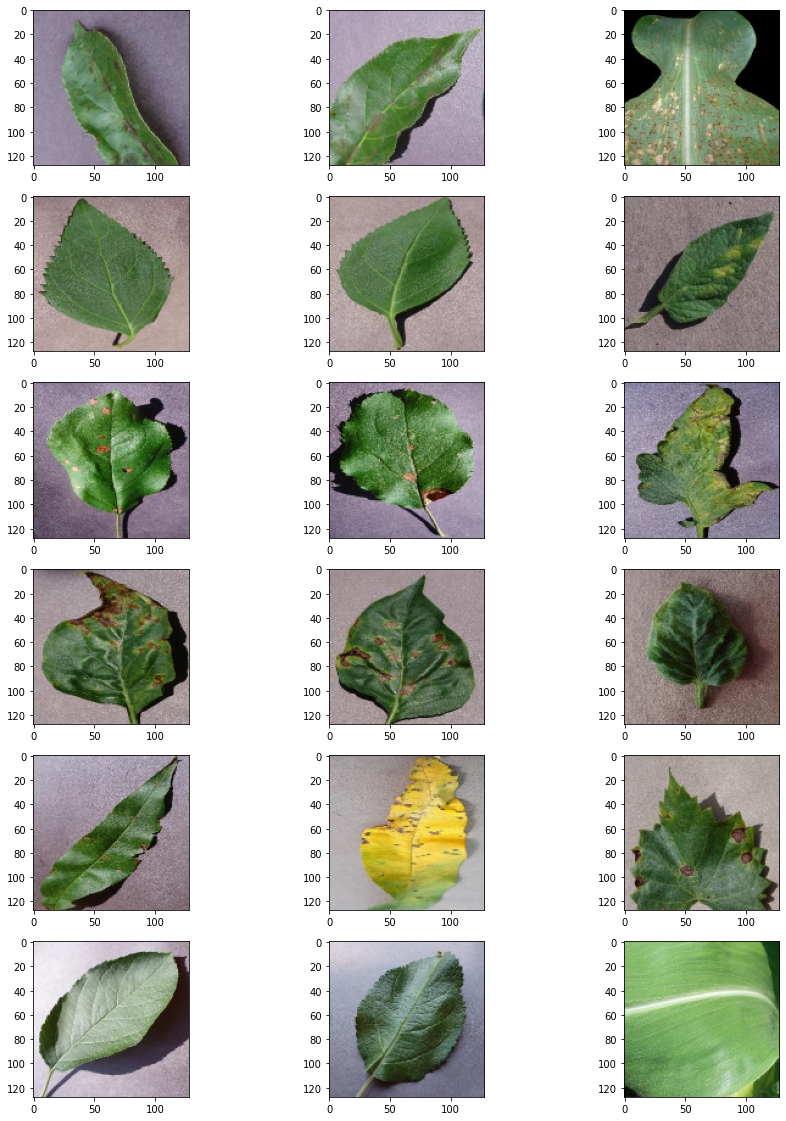

In [7]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet,train_images, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [8]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNet

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG19

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [9]:
def get_encoder(input_shape):
    
    """ Returns the image encoding model """
    tf.keras.backend.clear_session()
    # MobileNet(weights='imagenet', include_top=False, input_shape=input_shape,pooling='avg')
    pretrained_model =base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [10]:
# Define input shape for the encoder
input_shape = (128, 128, 3)  # Example input shape

# Get the encoder model
encoder = get_encoder(input_shape)

# Save the model
encoder.save('encoder_model.h5')
print("Encoder model saved successfully.")


80150528/80134624 [==============================] - 3s 0us/step
Encoder model saved successfully.


Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

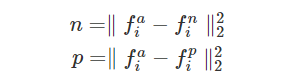

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    # encoded_a = encoder(anchor_input)
    # encoded_p = encoder(positive_input)
    # encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          24352576    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

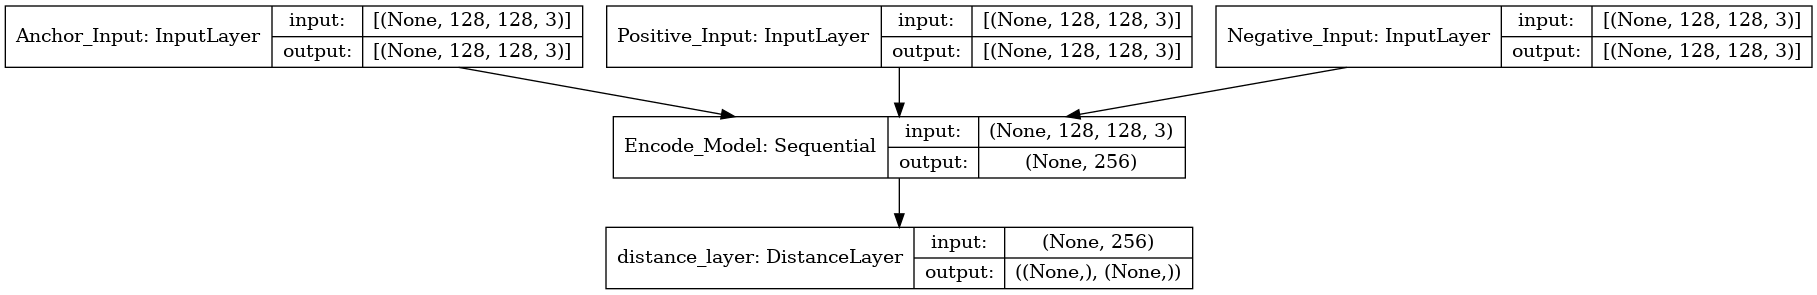

In [12]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [15]:
def test_on_triplets(batch_size=256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplet,val_images, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [16]:
save_all = False
epochs = 10
batch_size = 32

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet,train_images, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 40 sec)
Loss on train    = 0.45943
Accuracy on test = 0.84310

EPOCH: 2 	 (Epoch done in 22 sec)
Loss on train    = 0.26764
Accuracy on test = 0.88283

EPOCH: 3 	 (Epoch done in 21 sec)
Loss on train    = 0.18587
Accuracy on test = 0.83704

EPOCH: 4 	 (Epoch done in 21 sec)
Loss on train    = 0.20367
Accuracy on test = 0.86869

EPOCH: 5 	 (Epoch done in 21 sec)
Loss on train    = 0.18773
Accuracy on test = 0.88215

EPOCH: 6 	 (Epoch done in 21 sec)
Loss on train    = 0.13322
Accuracy on test = 0.88350

EPOCH: 7 	 (Epoch done in 21 sec)
Loss on train    = 0.10209
Accuracy on test = 0.90034

EPOCH: 8 	 (Epoch done in 21 sec)
Loss on train    = 0.08190
Accuracy on test = 0.90236

EPOCH: 9 	 (Epoch done in 21 sec)
Loss on train    = 0.08818
Accuracy on test = 0.90236

EPOCH: 10 	 (Epoch done in 21 sec)
Loss on train    = 0.07115
Accuracy on test = 0.89226


## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [17]:
# Saving the model after all epochs run
siamese_model.save("siamese_model-final")

In [18]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
Total params: 24,352,576
Trainable params: 24,351,552
Non-trainable params: 1,024
______________________________________

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [19]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.83984375



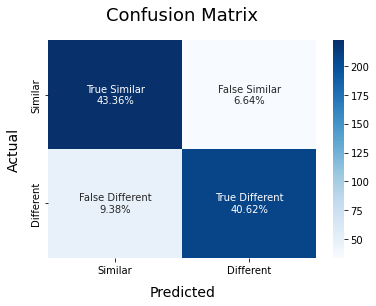

In [20]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(val_triplet,val_images, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

# STAGE 1

In [21]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [22]:
#read data
train_dir = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images"
val_dir = "/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images"


In [23]:
#Load
def build_dataset(data_dir):
    descriptors_list = []
    labels = []
    image_paths = []
    
    plant_type = { 
        'Apple': ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'],
        'Cherry': ['Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew'],
        'Corn': ['Corn___healthy', 'Corn___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn___Common_rust_', 'Corn___Northern_Leaf_Blight'],
        'Grape': ['Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'],
        'Peach': ['Peach___Bacterial_spot','Peach___healthy'],
        'Pepper': ['Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy'],
        'Potato': ['Potato___Early_blight','Potato___Late_blight','Potato___healthy '],
        'Strawberry': ['Strawberry___Leaf_scorch','Strawberry___healthy'],
        'Tomato': ['Tomato___Early_blight','Tomato___Bacterial_spot','Tomato___Late_blight ','Tomato___Leaf_Mold ','Tomato___Septoria_leaf_spot ','Tomato___Spider_mites Two-spotted_spider_mite ','Tomato___Target_Spot ','Tomato___Tomato_Yellow_Leaf_Curl_Virus ','Tomato___Tomato_mosaic_virus ','Tomato___healthy '],

    }
    
    for plant_type, subcategories in plant_type.items():
        for subcategory in subcategories:
            class_path = os.path.join(data_dir, subcategory)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    descriptors = extract_sift_features(image_path)
                    if descriptors is not None:
                        descriptors_list.append(descriptors)
                        labels.append(plant_type)
                        image_paths.append(image_path)
    
    return descriptors_list, labels, image_paths

In [24]:
#SIFT 
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [25]:
#BoW histograms
def compute_bow_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(kmeans.n_clusters)
        if descriptors is not None:
            cluster_assignments = kmeans.predict(descriptors)
            for cluster in cluster_assignments:
                histogram[cluster] += 1
        histograms.append(histogram)
    return np.array(histograms)


In [26]:
# sift(kp,des) -> clusture (kmeans) -> histogram

train_descriptors, train_labels, _ = build_dataset(train_dir)
all_descriptors = np.vstack(train_descriptors)
kmeans = KMeans(n_clusters=250, random_state=0).fit(all_descriptors)  
train_histograms = compute_bow_histograms(train_descriptors, kmeans)

In [27]:
#SVM model
svm = SVC(kernel='linear', random_state=0)
svm.fit(train_histograms, train_labels)
print("SVM Training complete!")

SVM Training complete!


In [28]:
#Save
joblib.dump(svm, 'plant_type_svm.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

print("saved complete!")

saved complete!


In [29]:
#validation dataset
val_descriptors, val_labels, val_image_paths = build_dataset(val_dir)

#BoW histogram for validation
val_histograms = compute_bow_histograms(val_descriptors, kmeans)

#Predict labels for validation data
val_predictions = svm.predict(val_histograms)

#overall validation accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

#each class validation accuracy
for plant_type in set(val_labels):
    val_indices = [i for i, label in enumerate(val_labels) if label == plant_type]
    val_class_accuracy = accuracy_score(
        [val_labels[i] for i in val_indices],
        [val_predictions[i] for i in val_indices],
    )
    print(f"Validation Accuracy for class {plant_type}: {val_class_accuracy:.4f}")

Validation Accuracy: 0.7450
Validation Accuracy for class Grape: 0.8250
Validation Accuracy for class Potato: 0.8000
Validation Accuracy for class Pepper: 0.7500
Validation Accuracy for class Strawberry: 0.8500
Validation Accuracy for class Peach: 0.6000
Validation Accuracy for class Apple: 0.7750
Validation Accuracy for class Cherry: 0.8000
Validation Accuracy for class Tomato: 0.4500


In [30]:
# Train Logistic
logistic_regression = LogisticRegression(max_iter=1000, random_state=0)
logistic_regression.fit(train_histograms, train_labels)

print("Logistic Regression Training complete!")

Logistic Regression Training complete!


In [31]:
# Saven Logistic
#joblib.dump(logistic_regression, 'plant_type_logistic_regression.pkl')

# Validate using Logistic 
val_predictions_lr = logistic_regression.predict(val_histograms)

# Overall validation accuracy for Logistic 
val_accuracy_lr = accuracy_score(val_labels, val_predictions_lr)
print(f"Logistic Regression Validation Accuracy: {val_accuracy_lr:.4f}")

# Each class validation accuracy for Logistic 
for plant_type in set(val_labels):
    val_indices = [i for i, label in enumerate(val_labels) if label == plant_type]
    val_class_accuracy_lr = accuracy_score(
        [val_labels[i] for i in val_indices],
        [val_predictions_lr[i] for i in val_indices],
    )
    print(f"Logistic Regression Validation Accuracy for class {plant_type}: {val_class_accuracy_lr:.4f}")

Logistic Regression Validation Accuracy: 0.7350
Logistic Regression Validation Accuracy for class Grape: 0.8250
Logistic Regression Validation Accuracy for class Potato: 0.8000
Logistic Regression Validation Accuracy for class Pepper: 0.8500
Logistic Regression Validation Accuracy for class Strawberry: 0.7500
Logistic Regression Validation Accuracy for class Peach: 0.5500
Logistic Regression Validation Accuracy for class Apple: 0.7500
Logistic Regression Validation Accuracy for class Cherry: 0.7000
Logistic Regression Validation Accuracy for class Tomato: 0.5500


In [32]:

# Train KNN
knn = KNeighborsClassifier(n_neighbors=20, metric='euclidean')
knn.fit(train_histograms, train_labels)

print("KNN Training complete!")

KNN Training complete!


In [33]:
# Save the KNN model
#joblib.dump(knn, 'plant_type_knn_classifier.pkl')

# Validate
val_predictions_knn = knn.predict(val_histograms)

# Overall validation accuracy
val_accuracy_knn = accuracy_score(val_labels, val_predictions_knn)
print(f"KNN Validation Accuracy: {val_accuracy_knn:.4f}")

# Each class validation accuracy 
for plant_type in set(val_labels):
    val_indices = [i for i, label in enumerate(val_labels) if label == plant_type]
    val_class_accuracy_knn = accuracy_score(
        [val_labels[i] for i in val_indices],
        [val_predictions_knn[i] for i in val_indices],
    )
    print(f"KNN Validation Accuracy for class {plant_type}: {val_class_accuracy_knn:.4f}")

KNN Validation Accuracy: 0.6150
KNN Validation Accuracy for class Grape: 0.7500
KNN Validation Accuracy for class Potato: 0.6000
KNN Validation Accuracy for class Pepper: 0.4000
KNN Validation Accuracy for class Strawberry: 0.4000
KNN Validation Accuracy for class Peach: 0.4500
KNN Validation Accuracy for class Apple: 0.9500
KNN Validation Accuracy for class Cherry: 0.6000
KNN Validation Accuracy for class Tomato: 0.3000


In [34]:
import time
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# SVM Training and Validation
start_time = time.time()
svm = SVC(kernel='linear', random_state=0)
svm.fit(train_histograms, train_labels)
training_time_svm = time.time() - start_time
train_predictions_svm = svm.predict(train_histograms)
train_accuracy_svm = accuracy_score(train_labels, train_predictions_svm)
print(f"SVM Training complete! Training time: {training_time_svm:.2f} seconds")
print(f"SVM Training Accuracy: {train_accuracy_svm:.4f}")

start_time = time.time()
val_predictions = svm.predict(val_histograms)
testing_time_svm = time.time() - start_time
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"SVM Validation Accuracy: {val_accuracy:.4f}")
print(f"SVM Testing time: {testing_time_svm:.2f} seconds")

# Logistic Regression Training and Validation
start_time = time.time()
logistic_regression = LogisticRegression(max_iter=1000, random_state=0)
logistic_regression.fit(train_histograms, train_labels)
training_time_lr = time.time() - start_time
train_predictions_lr = logistic_regression.predict(train_histograms)
train_accuracy_lr = accuracy_score(train_labels, train_predictions_lr)
print(f"Logistic Regression Training complete! Training time: {training_time_lr:.2f} seconds")
print(f"Logistic Regression Training Accuracy: {train_accuracy_lr:.4f}")

start_time = time.time()
val_predictions_lr = logistic_regression.predict(val_histograms)
testing_time_lr = time.time() - start_time
val_accuracy_lr = accuracy_score(val_labels, val_predictions_lr)
print(f"Logistic Regression Validation Accuracy: {val_accuracy_lr:.4f}")
print(f"Logistic Regression Testing time: {testing_time_lr:.2f} seconds")

# KNN Training and Validation
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(train_histograms, train_labels)
training_time_knn = time.time() - start_time
train_predictions_knn = knn.predict(train_histograms)
train_accuracy_knn = accuracy_score(train_labels, train_predictions_knn)
print(f"KNN Training complete! Training time: {training_time_knn:.2f} seconds")
print(f"KNN Training Accuracy: {train_accuracy_knn:.4f}")

start_time = time.time()
val_predictions_knn = knn.predict(val_histograms)
testing_time_knn = time.time() - start_time
val_accuracy_knn = accuracy_score(val_labels, val_predictions_knn)
print(f"KNN Validation Accuracy: {val_accuracy_knn:.4f}")
print(f"KNN Testing time: {testing_time_knn:.2f} seconds")


SVM Training complete! Training time: 0.06 seconds
SVM Training Accuracy: 1.0000
SVM Validation Accuracy: 0.7450
SVM Testing time: 0.01 seconds
Logistic Regression Training complete! Training time: 1.70 seconds
Logistic Regression Training Accuracy: 1.0000
Logistic Regression Validation Accuracy: 0.7350
Logistic Regression Testing time: 0.00 seconds
KNN Training complete! Training time: 0.00 seconds
KNN Training Accuracy: 0.7150
KNN Validation Accuracy: 0.6250
KNN Testing time: 0.02 seconds


SVM Training complete! Training time: 0.05 seconds
SVM Validation Accuracy: 0.7450
SVM Testing time: 0.01 seconds


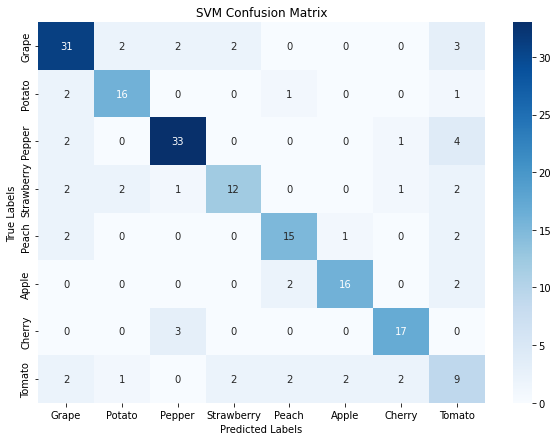

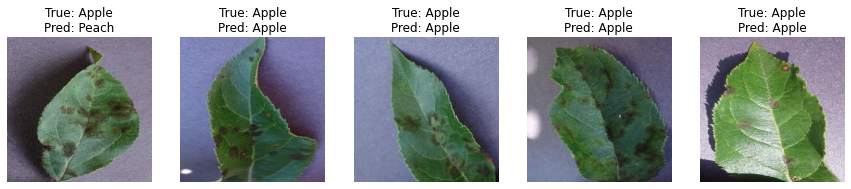

Logistic Regression Training complete! Training time: 1.57 seconds
Logistic Regression Validation Accuracy: 0.7350
Logistic Regression Testing time: 0.00 seconds


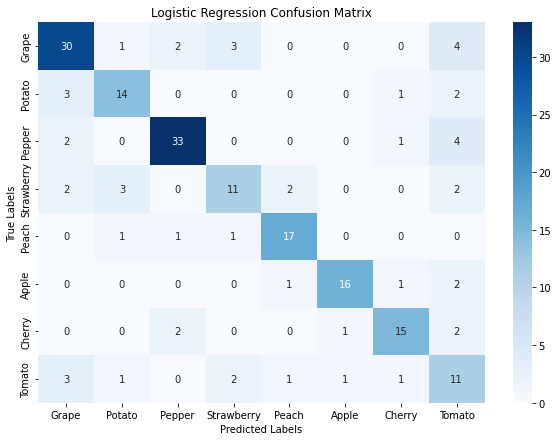

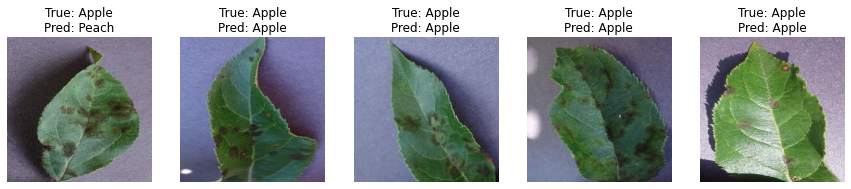

KNN Training complete! Training time: 0.00 seconds
KNN Validation Accuracy: 0.6250
KNN Testing time: 0.02 seconds


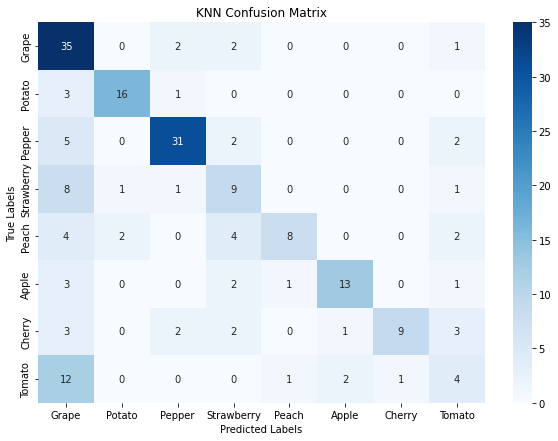

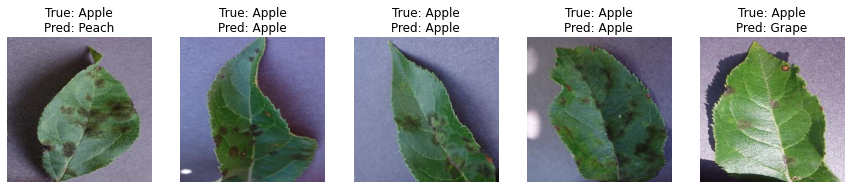

In [35]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Function to display sample images with true vs predicted labels
def display_sample_predictions(image_paths, true_labels, pred_labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        plt.subplot(1, num_samples, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

# SVM Training and Validation
start_time = time.time()
svm = SVC(kernel='linear', random_state=0)
svm.fit(train_histograms, train_labels)
training_time_svm = time.time() - start_time
print(f"SVM Training complete! Training time: {training_time_svm:.2f} seconds")

start_time = time.time()
val_predictions = svm.predict(val_histograms)
testing_time_svm = time.time() - start_time
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"SVM Validation Accuracy: {val_accuracy:.4f}")
print(f"SVM Testing time: {testing_time_svm:.2f} seconds")

# Confusion Matrix for SVM
plot_confusion_matrix(val_labels, val_predictions, classes=list(set(val_labels)), title="SVM Confusion Matrix")

# Display sample predictions for SVM
display_sample_predictions(val_image_paths, val_labels, val_predictions)

# Logistic Regression Training and Validation
start_time = time.time()
logistic_regression = LogisticRegression(max_iter=1000, random_state=0)
logistic_regression.fit(train_histograms, train_labels)
training_time_lr = time.time() - start_time
print(f"Logistic Regression Training complete! Training time: {training_time_lr:.2f} seconds")

start_time = time.time()
val_predictions_lr = logistic_regression.predict(val_histograms)
testing_time_lr = time.time() - start_time
val_accuracy_lr = accuracy_score(val_labels, val_predictions_lr)
print(f"Logistic Regression Validation Accuracy: {val_accuracy_lr:.4f}")
print(f"Logistic Regression Testing time: {testing_time_lr:.2f} seconds")

# Confusion Matrix for Logistic Regression
plot_confusion_matrix(val_labels, val_predictions_lr, classes=list(set(val_labels)), title="Logistic Regression Confusion Matrix")

# Display sample predictions for Logistic Regression
display_sample_predictions(val_image_paths, val_labels, val_predictions_lr)

# KNN Training and Validation
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(train_histograms, train_labels)
training_time_knn = time.time() - start_time
print(f"KNN Training complete! Training time: {training_time_knn:.2f} seconds")

start_time = time.time()
val_predictions_knn = knn.predict(val_histograms)
testing_time_knn = time.time() - start_time
val_accuracy_knn = accuracy_score(val_labels, val_predictions_knn)
print(f"KNN Validation Accuracy: {val_accuracy_knn:.4f}")
print(f"KNN Testing time: {testing_time_knn:.2f} seconds")

# Confusion Matrix for KNN
plot_confusion_matrix(val_labels, val_predictions_knn, classes=list(set(val_labels)), title="KNN Confusion Matrix")

# Display sample predictions for KNN
display_sample_predictions(val_image_paths, val_labels, val_predictions_knn)


# TEST SCRIPT 2

In [36]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the Encoder Model
encoder = load_model("/kaggle/working/encoder_model.h5")  # Update path to your encoder model

def read_image(image_path):
    """
    Read and preprocess an image for the encoder model.
    Args:
        image_path: Path to the image file.
    Returns:
        Preprocessed image as a numpy array.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}")
    image = cv2.resize(image, (128, 128))  # Resize to model input size
    image = image / 255.0  # Normalize pixel values
    return np.array(image)

def extract_disease_name(filename):
    """
    Extract the disease name from the file name.
    Args:
        filename: Name of the image file.
    Returns:
        Disease name after '__' in the filename.
    """
    if '__' in filename:
        return filename.split('__')[-1]
    return filename

def find_closest_match(anchor_image_path, folder_path, threshold=0.13):
    """
    Compare anchor image with images in the folder and return the closest match.
    Args:
        anchor_image_path: Path to the anchor image.
        folder_path: Path to the folder containing test images.
        threshold: Distance threshold for similarity.
    Returns:
        The disease name of the closest match or 'No Match'.
    """
    # Read and encode the anchor image
    anchor_image = read_image(anchor_image_path)
    anchor_tensor = encoder.predict(np.expand_dims(anchor_image, axis=0))

    min_distance = float("inf")
    closest_match = "No Match"

    # Loop through all test images
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Skip the anchor image itself
        if "Anchor" in filename:
            continue

        # Read and encode the current image
        test_image = read_image(file_path)
        test_tensor = encoder.predict(np.expand_dims(test_image, axis=0))

        # Compute the distance
        distance = np.sum(np.square(anchor_tensor - test_tensor))
        print(f"Distance to {filename}: {distance:.4f}")

        # Check if this is the closest match
        if distance < min_distance and distance <= threshold:
            min_distance = distance
            closest_match = extract_disease_name(filename)

    print(f"Closest match: {closest_match} with distance: {min_distance:.4f}")
    return closest_match

# Folder and file paths
folder_path = "/kaggle/input/test-4/test stage2"  # Update folder path
anchor_image_path = os.path.join(folder_path, "/kaggle/input/test-4/test stage2/Anchor.JPG")




In [37]:
# Find the closest match
result = find_closest_match(anchor_image_path, folder_path, threshold=1.3)
print(f"Matched Disease: {result}")

Distance to Tomato___Tomato_Yellow_Leaf_Curl_Virus.JPG: 0.1196
Distance to Apple___Cedar_apple_rust.JPG: 0.0669
Distance to Cherry_(including_sour)___healthy.JPG: 0.1366
Distance to Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot.JPG: 0.1094
Distance to Grape___Esca_(Black_Measles).JPG: 0.0000
Distance to Apple___Apple_scab.JPG: 0.0932
Closest match: _Esca_(Black_Measles).JPG with distance: 0.0000
Matched Disease: _Esca_(Black_Measles).JPG


# test script part 1

In [38]:
import cv2
import os
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from skimage.feature import SIFT
import matplotlib.pyplot as plt


# Load SVM model and KMeans model
svm_model = joblib.load('plant_type_svm.pkl')
kmeans_model = joblib.load('kmeans_model.pkl')

# Load Siamese network model
siamese_model = tf.keras.models.load_model('siamese_model-final')

In [39]:
def classify_plant_type(image_path):
    descriptors = extract_sift_features(image_path)
    if descriptors is not None:
        histogram = compute_bow_histograms([descriptors], kmeans_model)
        plant_type = svm_model.predict(histogram)
        return plant_type[0]
    return None

In [40]:
# Plant types and their corresponding disease categories
plant_types = {
    'Apple': ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'],
    'Cherry': ['Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew'],
    'Corn': ['Corn___healthy', 'Corn___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn___Common_rust_', 'Corn___Northern_Leaf_Blight'],
    'Grape': ['Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___healthy','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'],
    'Peach': ['Peach___Bacterial_spot','Peach___healthy'],
    'Pepper': ['Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy'],
    'Potato': ['Potato___Early_blight','Potato___Late_blight','Potato___healthy'],
    'Strawberry': ['Strawberry___Leaf_scorch','Strawberry___healthy'],
    'Tomato': ['Tomato___Early_blight','Tomato___Bacterial_spot','Tomato___Late_blight ','Tomato___Leaf_Mold ','Tomato___Septoria_leaf_spot ','Tomato___Spider_mites Two-spotted_spider_mite ','Tomato___Target_Spot ','Tomato___Tomato_Yellow_Leaf_Curl_Virus ','Tomato___Tomato_mosaic_virus ','Tomato___healthy ']
}

In [41]:
def get_disease_list(plant_type):
    disease_list = plant_types[plant_type]
    return disease_list

In [42]:
def normalize_name(name):
    """
    Normalize disease or folder name to match naming conventions.
    """
    return name.lower().replace(" ", "_").replace(",", "_").replace("(", "_").replace(")", "_").replace("-", "_")

In [43]:
def find_matching_folder(base_path, disease_name):
    """
    Finds the matching folder for a given disease name in the base path.
    """
    normalized_disease = normalize_name(disease_name)
    for folder in os.listdir(base_path):
        if normalize_name(folder) == normalized_disease:
            return os.path.join(base_path, folder)
    return None

In [44]:
def recognize_disease(image_path, plant_type, disease_list, base_path="/kaggle/input/supportset/Test-Stage2-Part1"):
    """
    Recognizes the disease of a given plant image.
    """
    # Load and preprocess the test image
    anchor_image = cv2.imread(image_path)
    if anchor_image is None:
        raise ValueError(f"Test image not found at {image_path}")
    
    anchor_image = cv2.cvtColor(anchor_image, cv2.COLOR_BGR2RGB)
    anchor_image = cv2.resize(anchor_image, (128, 128)) / 255.0

    min_distance = float('inf')
    predicted_disease = "Unknown"

    for disease in disease_list:
        # Find the matching folder
        disease_folder_path = find_matching_folder(base_path, disease)
        print(f"Checking disease folder: {disease_folder_path}")

        if not disease_folder_path:
            print(f"Disease folder not found: {disease}")
            continue

        for file_name in os.listdir(disease_folder_path):
            file_path = os.path.join(disease_folder_path, file_name)
            if not (file_path.endswith(".JPG") or file_path.endswith(".PNG")):
                continue

            # Compare images (dummy logic here, replace with actual similarity measure)
            support_image = cv2.imread(file_path)
            # print(support_image)
            support_image = cv2.resize(support_image, (128, 128)) / 255.0
            distance = np.linalg.norm(anchor_image - support_image)
            if distance < min_distance:
                min_distance = distance
                predicted_disease = disease

    return predicted_disease, min_distance

In [45]:
def classify_plant_and_disease(image_path):
    # Step 1: Classify Plant Type
    plant_type = classify_plant_type(image_path)
    # if plant_type is None:
    #     print("Could not classify plant type")
    #     return

    print(f"Plant Type: {plant_type}")

    # Step 2: Disease Recognition for the Plant Type
    disease_list = get_disease_list(plant_type)
    # if not disease_list:
    #     print(f"No diseases found for plant type: {plant_type}")
    #     return

    predicted_disease, distance = recognize_disease(image_path, plant_type, disease_list)
    if predicted_disease is None:
        print("Could not recognize disease")
    else:
        print(f"Predicted Disease: {predicted_disease} with distance {distance:.4f}")

In [46]:
# image_path = "/kaggle/input/supportset/Test-Stage2-Part1/Cherry_(including_sour)___Powdery_mildew/00e0a4ab-ecbd-4560-a71c-b19d86bb087c___FREC_Pwd.M 4917.JPG"  # Path to the test image
# classify_plant_and_disease(image_path)

In [47]:
import os
import cv2
import numpy as np

def evaluate_on_dataset(base_test_path, base_support_path):
    total_images = 0
    correct_predictions = 0
    misclassifications = []

    # Iterate over plant type folders in the test dataset
    for plant_folder in os.listdir(base_test_path):
        plant_folder_path = os.path.join(base_test_path, plant_folder)
        if not os.path.isdir(plant_folder_path):
            continue

        # Iterate over images in the plant folder
        for image_file in os.listdir(plant_folder_path):
            image_path = os.path.join(plant_folder_path, image_file)
            if not (image_path.endswith(".JPG") or image_path.endswith(".PNG")):
                continue
            
            total_images += 1

            # Step 1: Classify plant type
            predicted_plant_type = classify_plant_type(image_path)  # Replace with your SVM classification function
            
            # Step 2: Recognize disease
            disease_list = get_disease_list(predicted_plant_type)  # Fetch diseases for predicted plant type
            predicted_disease, _ = recognize_disease(image_path, predicted_plant_type, disease_list, base_support_path)
            
            # Step 3: Ground truth extraction
            ground_truth_disease = normalize_name(plant_folder) # Normalize folder name for comparison
            
            # Step 4: Evaluate prediction
            if ground_truth_disease == normalize_name(predicted_disease):
                correct_predictions += 1
            else:
                misclassifications.append({
                    "image": image_path,
                    "ground_truth": ground_truth_disease,
                    "predicted": normalize_name(predicted_disease)
                })

    # Calculate accuracy
    accuracy = correct_predictions / total_images if total_images > 0 else 0

    return {
        "total_images": total_images,
        "correct_predictions": correct_predictions,
        "accuracy": accuracy,
        "misclassifications": misclassifications
    }

In [48]:
test_dataset_path = "/kaggle/input/unseen2/Test-Unseen-Data"
support_dataset_path = "/kaggle/input/support/Test-Stage2-Part1-Support-Set"

results = evaluate_on_dataset(test_dataset_path, support_dataset_path)

# Display results
print(f"Total Images: {results['total_images']}")
print(f"Correct Predictions: {results['correct_predictions']}")
print(f"Accuracy: {results['accuracy'] * 100:.2f}%")

# Display misclassified examples
print("\nMisclassifications:")
for misclassified in results['misclassifications']:
    print(f"Image: {misclassified['image']}")
    print(f"  Ground Truth: {misclassified['ground_truth']}")
    print(f"  Predicted: {misclassified['predicted']}")

Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Grape___Black_rot
Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Grape___Esca_(Black_Measles)
Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Grape___healthy
Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Tomato___Early_blight
Checking disease folder: /kaggle/input/support/Test-Stage2-Part1-Support-Set/Tomato___Bacterial_spot
Checking disease folder: None
Disease folder not found: Tomato___Late_blight 
Checking disease folder: None
Disease folder not found: Tomato___Leaf_Mold 
Checking disease folder: None
Disease folder not found: Tomato___Septoria_leaf_spot 
Checking disease folder: None
Disease folder not found: Tomato___Spider_mites Two-spotted_spider_mite 
Checking disease folder: None
Disease folder